### Reference
https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/cliff_walking.py 

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

In [19]:
N_ROWS = 4
N_COLS = 12

ALPHA = 0.5 # defaut step size
GAMMA = 1 # discount factor, set to 1 for episodic task
EPSILON = 0.1 # epsilon-greedy 

# Possible actions
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

# states
START = (3, 0)
GOAL = (3, 11)

In [13]:
def step(state, action):
    r, c = state
    if action == UP:
        next_state = (max(r - 1, 0), c)
    elif action == DOWN:
        next_state = (min(r + 1, N_ROWS - 1), c)
    elif action == LEFT:
        next_state = (r, max(c - 1, 0))
    elif action == RIGHT:
        next_state = (r, min(c + 1, N_COLS - 1))
    else:
        assert False 
        
    reward = -1
    
    if (action == DOWN and r == 2 and 1 <= c <= 10) or (action == RIGHT and state == START):
        reward = -100
        next_state = START
        
    return next_state, reward 


In [18]:
def choose_action(state, Q):
    if np.random.random() < EPISOLON:
        return np.random.choice(ACTIONS)
    else:
        q_values = Q[state[0], state[1], :]
        best_actions = [a for a, value in enumerate(q_values) if value == np.max(q_values)]
        return np.random.choice(best_actions)
        

In [20]:
def sarsa(Q, step_size=ALPHA, expected=False) -> float:
    # Run one episode of on-policy TD(0) control with Sarsa
    #
    # @Q: the state-action value Q(S, A) 
    # @step_size: alpha 
    # @expected: expected Sarsa or not
    # @return the cumulative reward in this episode
    state = START
    action = choose_action(state, Q)
    cumulative_rewards = 0.
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, Q)
        cumulative_rewards += reward
        
        if not expected:
            # Q(S_t, A_t) <- Q(S_t, A_t) + \alpha * [R_{t+1} + \gamma * Q(S_{t + 1}, A_{t + 1}) - Q(S_t, A_t)]
            target = Q[next_state[0], next_state[1], next_action]
        else:
            # # Q(S_t, A_t) <- Q(S_t, A_t) + \alpha * [R_{t+1} + \gamma * \sum_a \pi(a | S_{t+1}) Q(S_{t + 1}, a) - Q(S_t, A_t)]
            target = 0.
            q_values = Q[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_values == np.max(q_values)) 
            for a in ACTIONS:
                if a in best_actions:
                    pi_a_s = (1. - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)
                else:
                    pi_a_s = EPSILON / len(ACTIONS)
                target += pi_a_s * Q[next_state[0], next_state[1], a]                
        target *= GAMMA
        
        Q[state[0], state[1], action] += step_size * (reward + target - Q[state[0], state[1], action])
        
        state = next_state
        action = next_action
        
    return cumulative_rewards
        

In [25]:
def q_learning(Q, step_size=ALPHA) -> float:
    # Run one episode of on-policy TD(0) control with Q-learning
    #
    # @Q: the state-action value Q(S, A) 
    # @step_size: alpha 
    # @return the cumulative reward in this episode
    state = START
    action = choose_action(state, Q)
    cumulative_rewards = 0.
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, Q) # not used in the Q(S, A) update
        cumulative_rewards += reward
        
        q_values = Q[next_state[0], next_state[1], :]
        target = np.max(q_values)
        Q[state[0], state[1], action] += step_size * (reward + GAMMA * target - Q[state[0], state[1], action])
        
        state = next_state
        action = next_action
        
    return cumulative_rewards
    

In [64]:
def print_optimal_ploicy(Q_value):
    policy = [[''] * N_COLS for _ in range(N_ROWS)]
    mapping = {
        UP: "U",
        DOWN: "D",
        LEFT: "L",
        RIGHT: "R"
    }
    
    for r in range(N_ROWS):
        for c in range(N_COLS):
            if (r, c) == GOAL:
                policy[r][c] = "G"
                continue
            best_action = np.argmax(Q_value[r, c, :])
            policy[r][c] = mapping[best_action]
            
    for r in range(N_ROWS):
        print(policy[r])


In [52]:
num_runs = 100
num_episodes = 500

rewards_sarsa = np.zeros(num_episodes)
rewards_expected_sarsa = np.zeros(num_episodes)
rewards_q_learning = np.zeros(num_episodes)

for run_idx in tqdm(range(num_runs)):
    Q_sarsa = np.random.randn(N_ROWS, N_COLS, 4)
    Q_expected_sarsa = np.random.randn(N_ROWS, N_COLS, 4)
    Q_q_learning = np.random.randn(N_ROWS, N_COLS, 4)
    for i in range(num_episodes):
        rewards_sarsa[i] += sarsa(Q_sarsa)
        rewards_expected_sarsa[i] += sarsa(Q_expected_sarsa, expected=True)
        rewards_q_learning[i] += q_learning(Q_q_learning)

rewards_sarsa /= num_runs
rewards_expected_sarsa /= num_runs
rewards_q_learning /= num_runs


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


In [65]:
# Sarsa policy
print_optimal_ploicy(Q_sarsa)

['D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'U', 'U', 'D', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'R', 'L', 'L', 'R', 'D']
['U', 'R', 'R', 'U', 'D', 'L', 'L', 'U', 'U', 'R', 'L', 'G']


In [66]:
# Expected Sarsa policy
print_optimal_ploicy(Q_expected_sarsa)

['L', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'L', 'U', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'D', 'U', 'L', 'D', 'L', 'L', 'L', 'R', 'D', 'U', 'G']


In [67]:
# Q-learning
print_optimal_ploicy(Q_q_learning)

['R', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['D', 'U', 'D', 'R', 'R', 'D', 'D', 'R', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'D', 'L', 'R', 'L', 'D', 'D', 'L', 'R', 'D', 'G']


In [57]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label1.set_fontsize(x_fontsize)
        tick.label1.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label1.set_fontsize(y_fontsize)
        tick.label1.set_rotation(y_rotation)

### Plot total reward within episode as a function of episode 

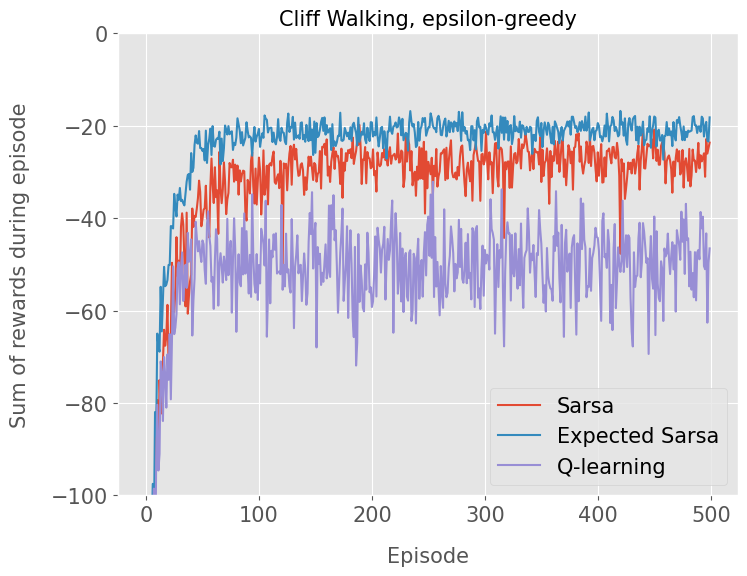

In [58]:
fontsize = 15
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.plot(rewards_sarsa, label="Sarsa")
ax.plot(rewards_expected_sarsa, label="Expected Sarsa")
ax.plot(rewards_q_learning, label="Q-learning")
ax.set_xlabel("Episode", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Sum of rewards during episode", fontsize=fontsize, labelpad=15)
ax.set_ylim(-100, 0)
ax.legend(loc="best", fontsize=fontsize)
ax.set_title("Cliff Walking, epsilon-greedy", fontsize=fontsize)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)

## Plot sum of rewards per episode as a function of step size $\alpha$

In [76]:
num_runs = 10
num_episodes = 50000
step_sizes = np.arange(0.1, 1.1, 0.1)

summary = np.zeros((3, len(step_sizes)))

for run_idx in range(num_runs):
    for i, step_size in tqdm(enumerate(step_sizes)):
        Q_sarsa = np.zeros((N_ROWS, N_COLS, 4))
        Q_expected_sarse = np.zeros((N_ROWS, N_COLS, 4))
        Q_q_learning = np.zeros((N_ROWS, N_COLS, 4))
        for episode_idx in range(num_episodes):
            summary[0, i] += sarsa(Q_sarsa, step_size=step_size)
            summary[1, i] += sarsa(Q_expected_sarse, step_size=step_size, expected=True)
            summary[2, i] += q_learning(Q_q_learning, step_size=step_size)

summary /= (num_runs * num_episodes) 

10it [08:18, 49.81s/it]
10it [08:22, 50.21s/it]
10it [08:23, 50.36s/it]
10it [08:28, 50.90s/it]
10it [08:25, 50.57s/it]
10it [09:38, 57.87s/it]
10it [41:47, 250.77s/it]
10it [1:24:33, 507.34s/it] 
10it [08:13, 49.33s/it]
10it [08:23, 50.38s/it]


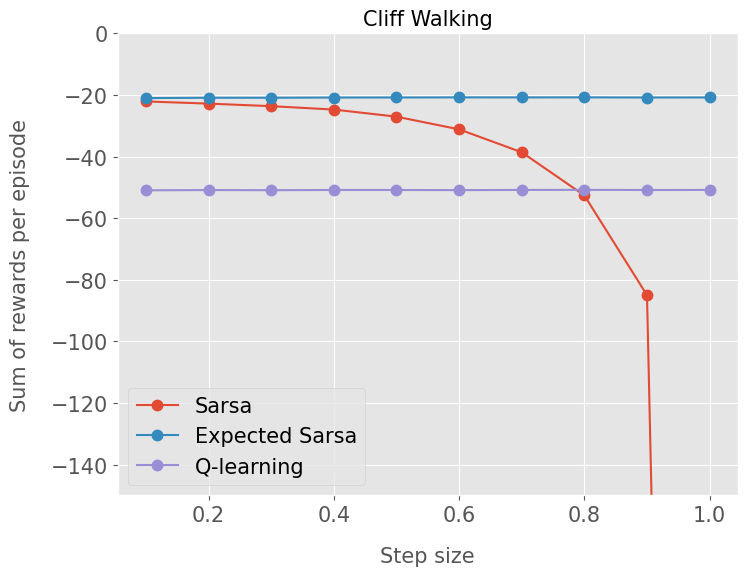

In [ ]:
fontsize = 15
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.plot(step_sizes, summary[0], marker=".", markersize=15, label="Sarsa")
ax.plot(step_sizes, summary[1], marker=".", markersize=15, label="Expected Sarsa")
ax.plot(step_sizes, summary[2], marker=".", markersize=15, label="Q-learning")
ax.set_ylim(-150, 0)
ax.legend(loc="best", fontsize=fontsize)
ax.set_xlabel("Step size", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Sum of rewards per episode", fontsize=fontsize, labelpad=15)
ax.set_title("Cliff Walking", fontsize=fontsize)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)